# 02 - Color Transform and Gradients Threshold

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

## Loading camera calibration

See: 01 - Camera Calibration.ipynb

In [2]:
cameraCalibration = pickle.load( open('./camera_calibration.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

## Load test images

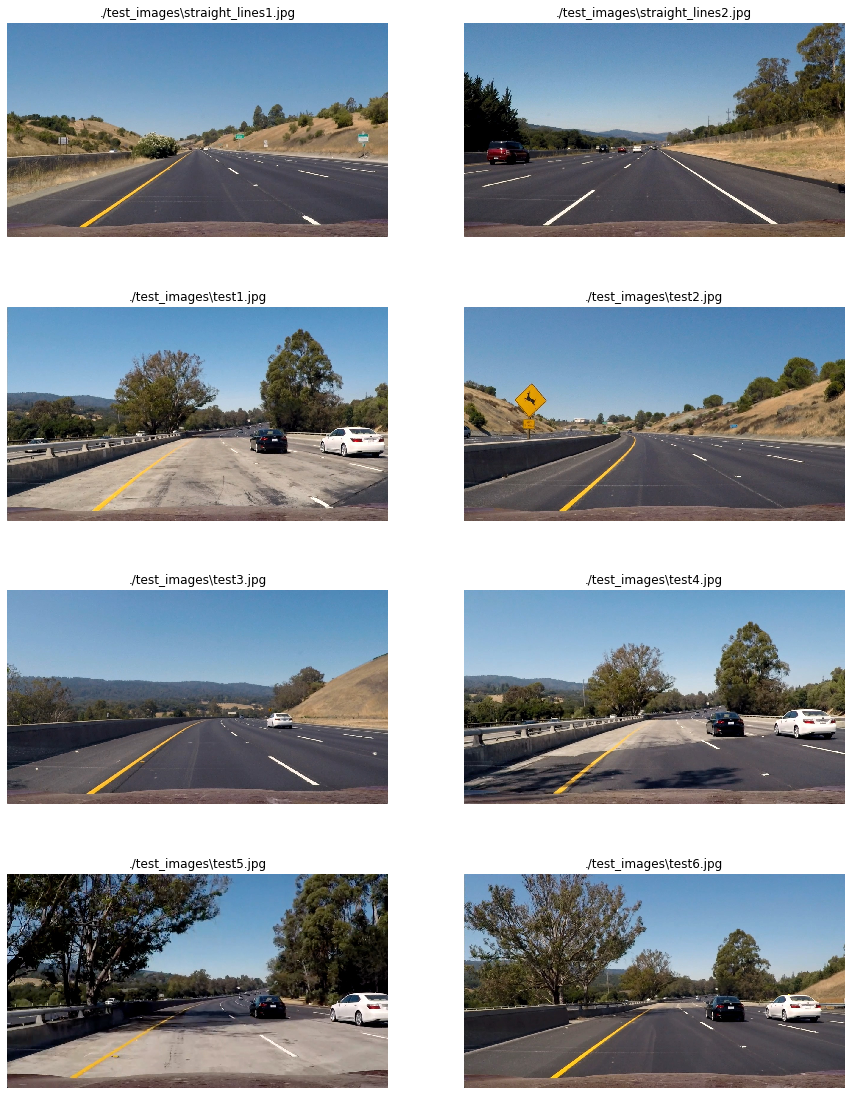

In [3]:
testImages = []
fileNames = sorted(glob.glob('./test_images/*.jpg'))
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 20))
for ax, fileName in zip(axes.flat, fileNames):
    img = cv2.imread(fileName)
    testImages.append(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(fileName)
    ax.axis('off')

## Undistort test images with mtx, dist and convert it to HLS

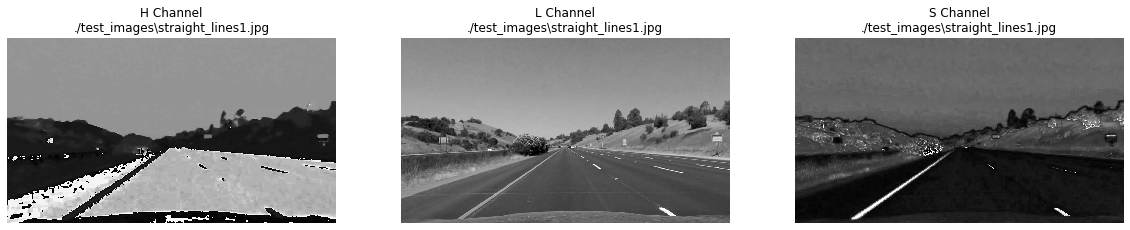

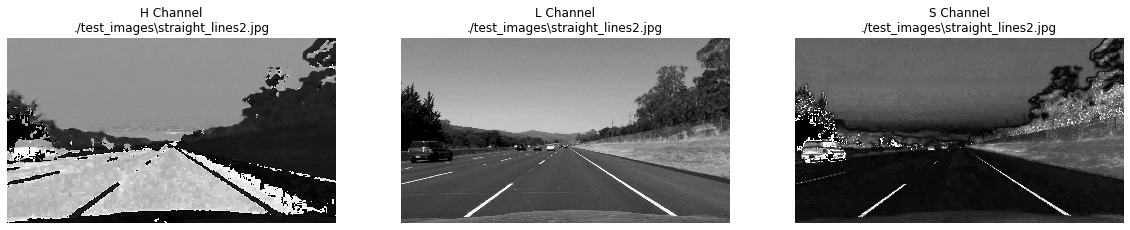

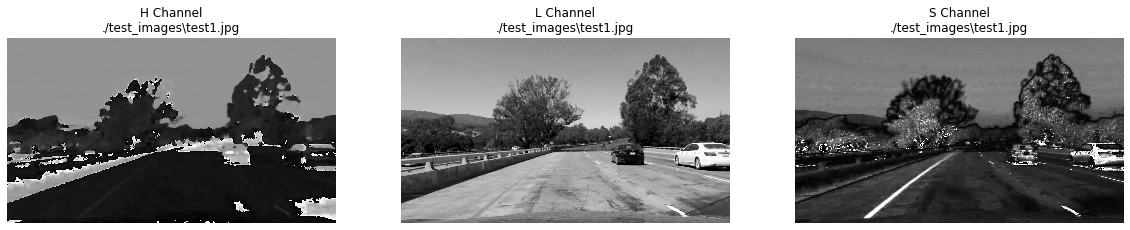

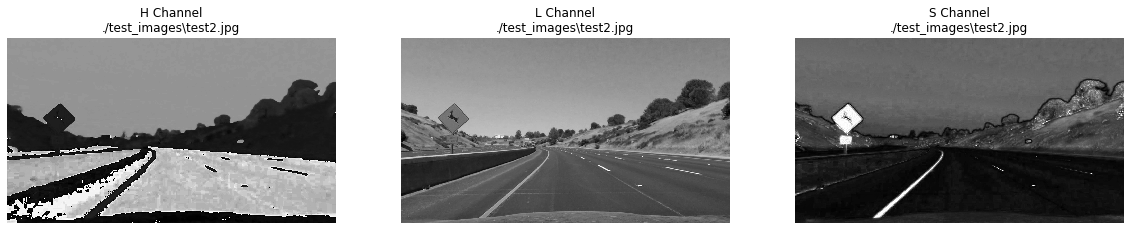

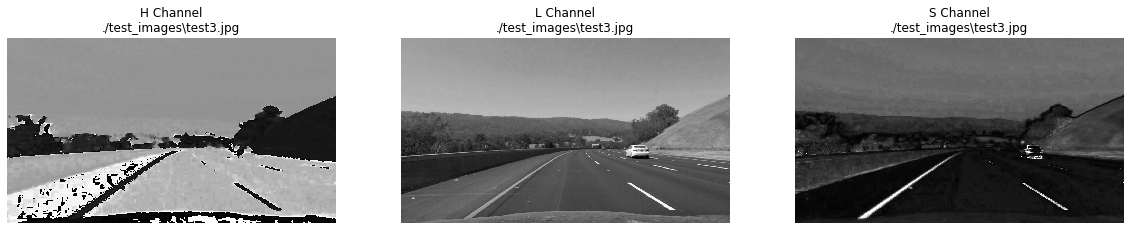

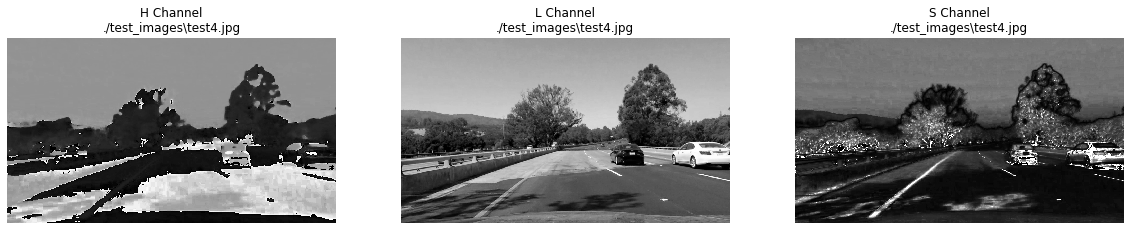

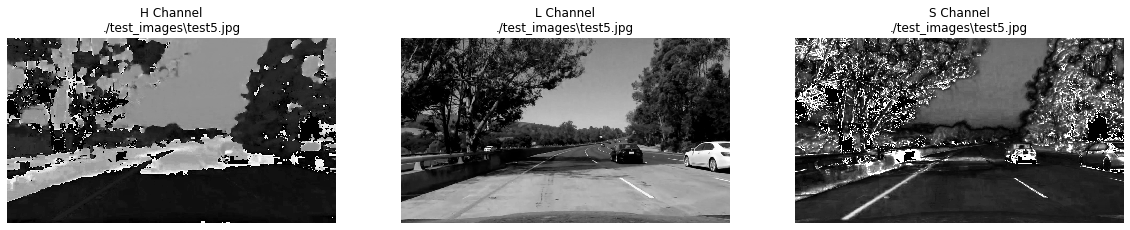

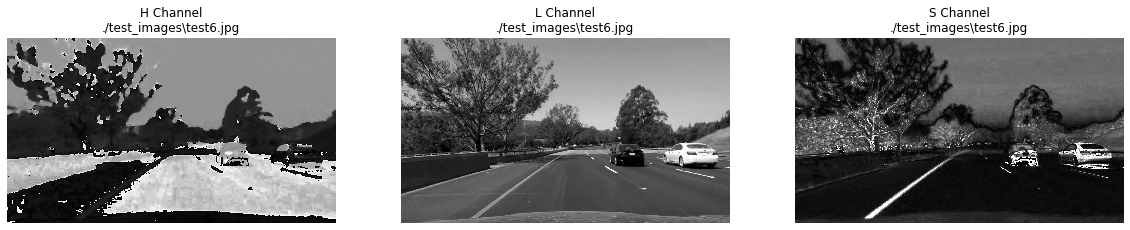

In [4]:
def undistortHLS(image, mtx=mtx, dist=dist):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)

for testImage, fileName in zip(testImages, fileNames):
    hlsOriginal = undistortHLS(testImage)
    fig, axes = plt.subplots(ncols=3, figsize=(20,15))
    for index, ax in enumerate(axes):
        ax.imshow(hlsOriginal[:,:,index], cmap='gray')
        ax.set_title(['H','L','S'][index]+' Channel\n'+fileName)
        ax.axis('off')

## Choose the best channel

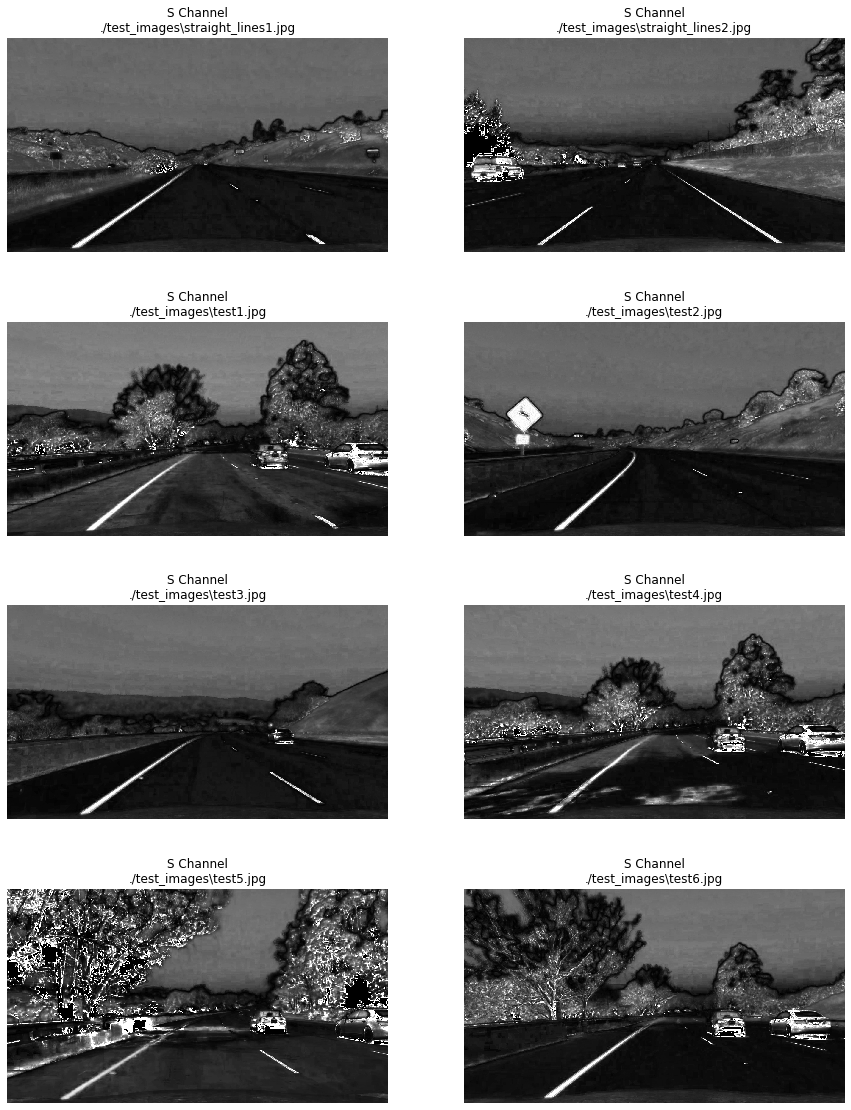

In [5]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 20))
testImagesSChannel = []
for ax, fileName, testImage in zip(axes.flat, fileNames, testImages):
    SChannel = undistortHLS(testImage)[:,:,2]
    testImagesSChannel.append(SChannel)
    ax.imshow(SChannel, cmap='gray')
    ax.set_title('S Channel\n'+fileName)
    ax.axis('off')

## Sobel

In [6]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    if(len(img.shape)==3):    
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img.copy()
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255.0*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Return the result
    return binary_output    

## Sobel Orientation x

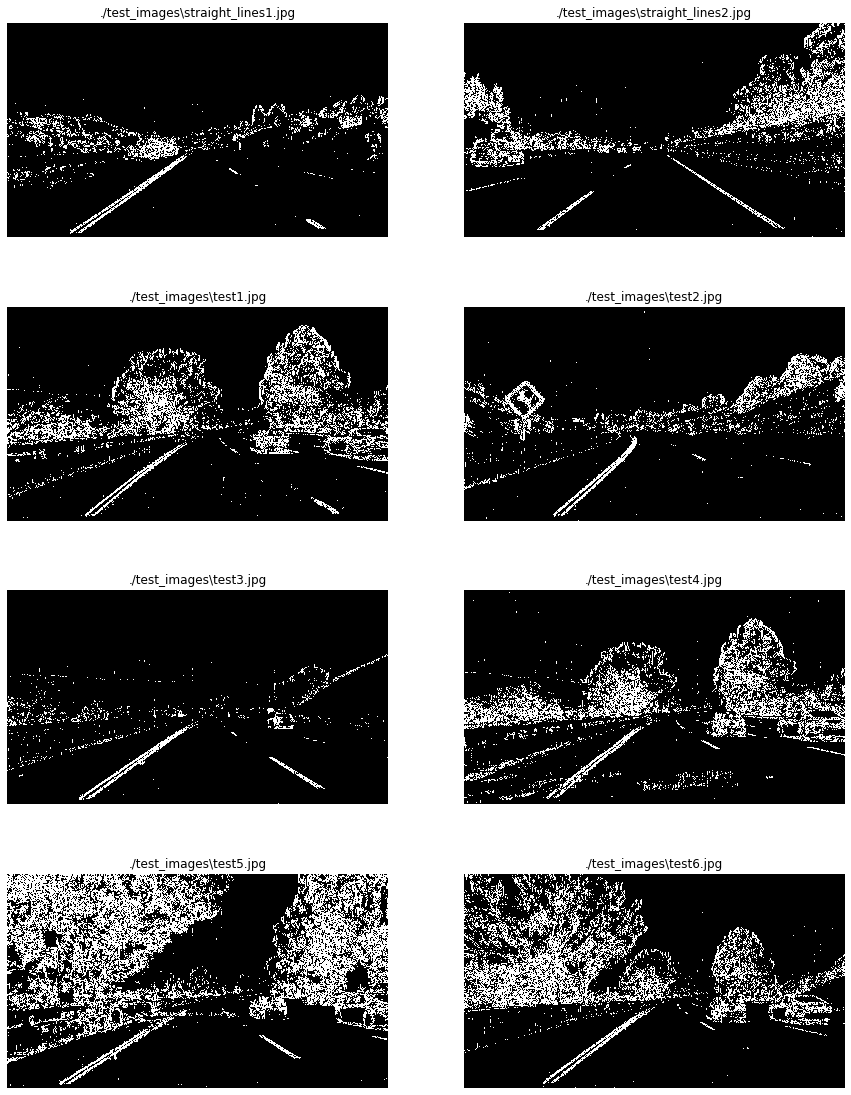

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 20))
gradsX = []
for ax, fileName, imgSChannel in zip(axes.flat, fileNames, testImagesSChannel):
    gradX = abs_sobel_thresh(imgSChannel, orient='x', thresh_min=10, thresh_max=160)
    gradsX.append(gradX)
    ax.imshow(gradX, cmap='gray')
    ax.set_title(fileName)
    ax.axis('off')

## Sobel Orientation y

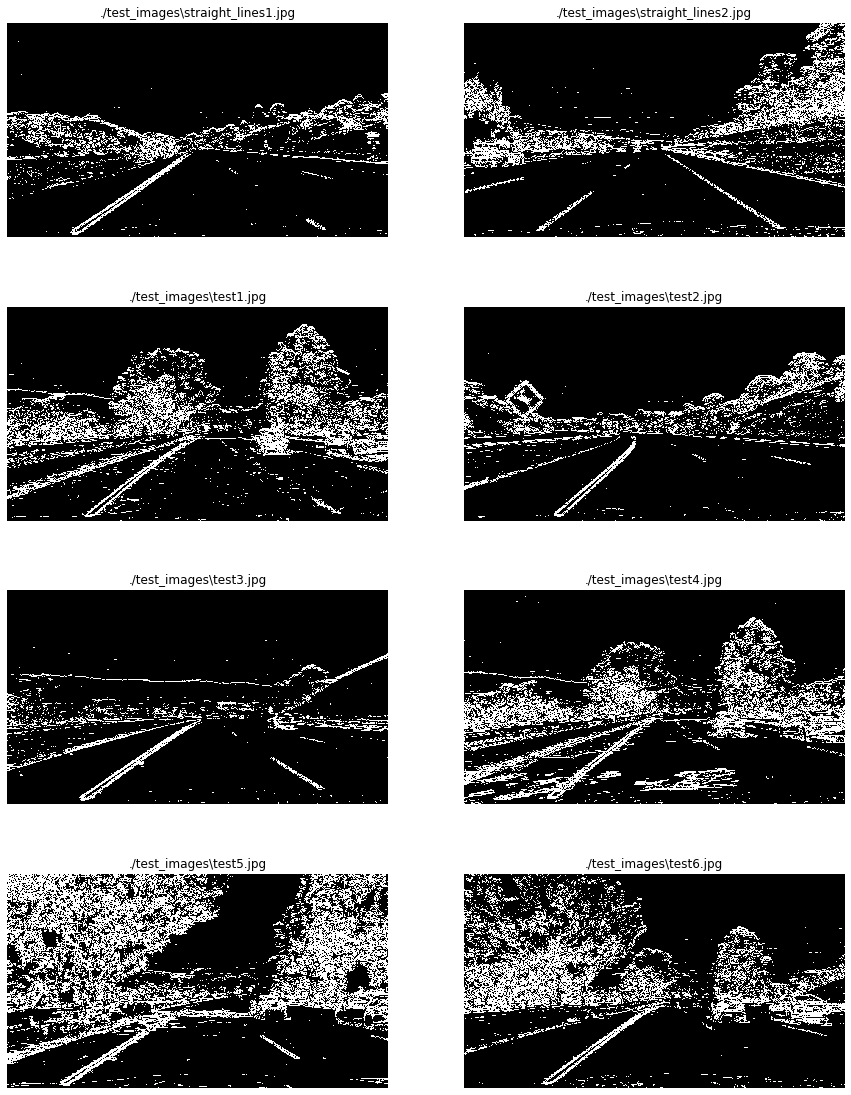

In [8]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 20))
gradsY = []
for ax, fileName, imgSChannel in zip(axes.flat, fileNames, testImagesSChannel):
    gradY = abs_sobel_thresh(imgSChannel, orient='y', thresh_min=10, thresh_max=160)
    gradsY.append(gradY)
    ax.imshow(gradY, cmap='gray')
    ax.set_title(fileName)
    ax.axis('off')

## Magnitude Gradient

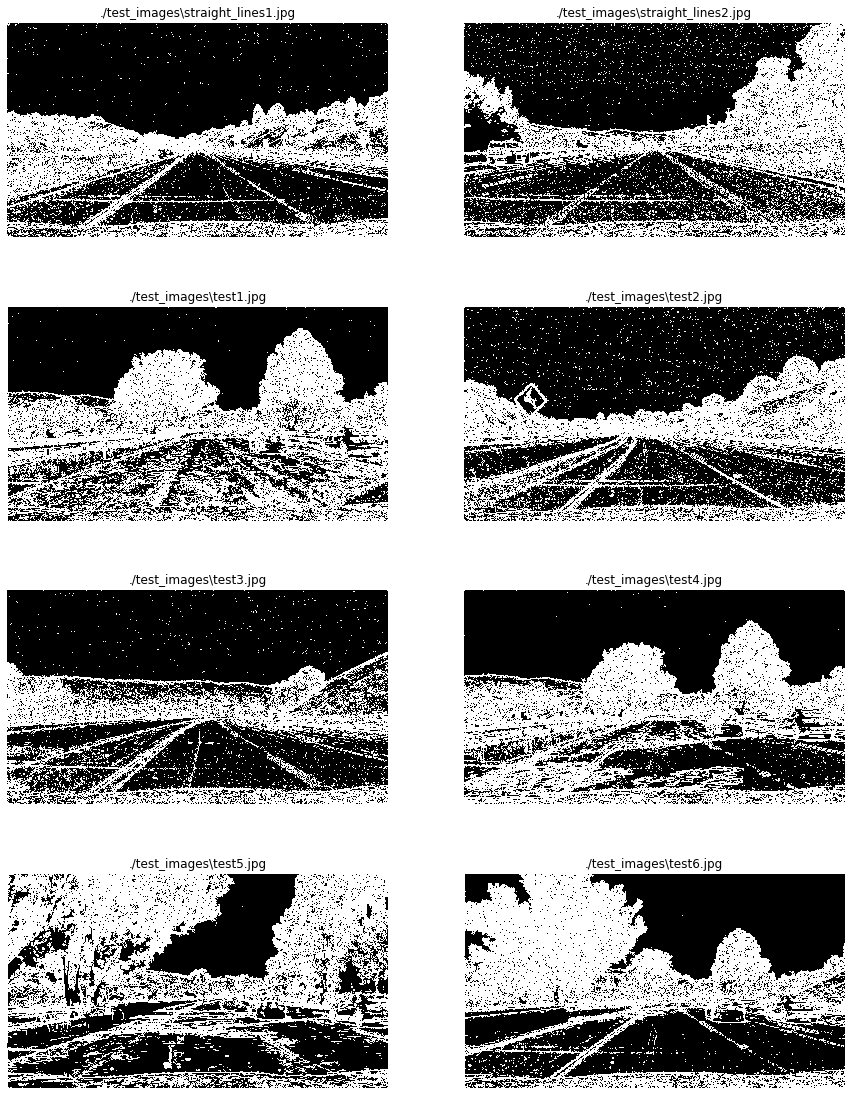

In [9]:
def mag_thresh(img, sobelKernel=3, magThresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobelKernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobelKernel)
    # Calculate the gradient magnitude
    gradMag = np.sqrt(sobelX**2 + sobelY**2)
    # Rescale to 8 bit
    scaleFactor = np.max(gradMag)/255 
    gradMag = (gradMag/scaleFactor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binaryOutput = np.zeros_like(gradMag)
    binaryOutput[(gradMag >= magThresh[0]) & (gradMag <= magThresh[1])] = 1
    # Return the binary image
    return binaryOutput

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 20))
magBinary = []
for ax, fileName, testImage in zip(axes.flat, fileNames, testImages):
    magBin = mag_thresh(testImage, sobelKernel=3, magThresh=(5, 160))
    magBinary.append(magBin)
    ax.imshow(magBin, cmap='gray')
    ax.set_title(fileName)
    ax.axis('off')

## Direction of Gradient 

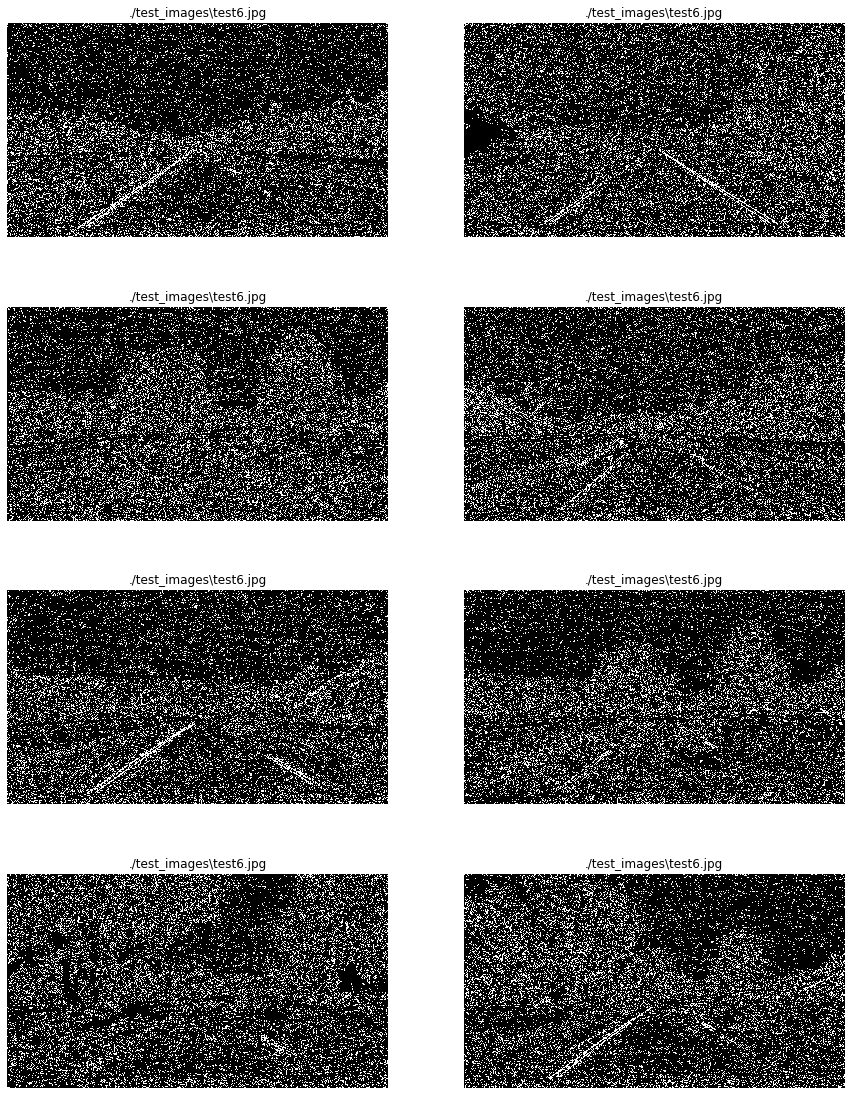

In [10]:
def dir_threshold(img, sobelKernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobelKernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobelKernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absGradDir = np.arctan2(np.absolute(sobelY), np.absolute(sobelX))
    binaryOutput =  np.zeros_like(absGradDir)
    binaryOutput[(absGradDir >= thresh[0]) & (absGradDir <= thresh[1])] = 1
    # Return the binary image
    return binaryOutput

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 20))
dirBinary = []
for ax, fname, testImage in zip(axes.flat, fileNames, testImages):
    dirBin = dir_threshold(testImage, sobelKernel=3, thresh=(0.79, 1.20))
    dirBinary.append(dirBin)
    ax.imshow(dirBin, cmap='gray')
    ax.set_title(fileName)
    ax.axis('off')

## Combining Thresholds

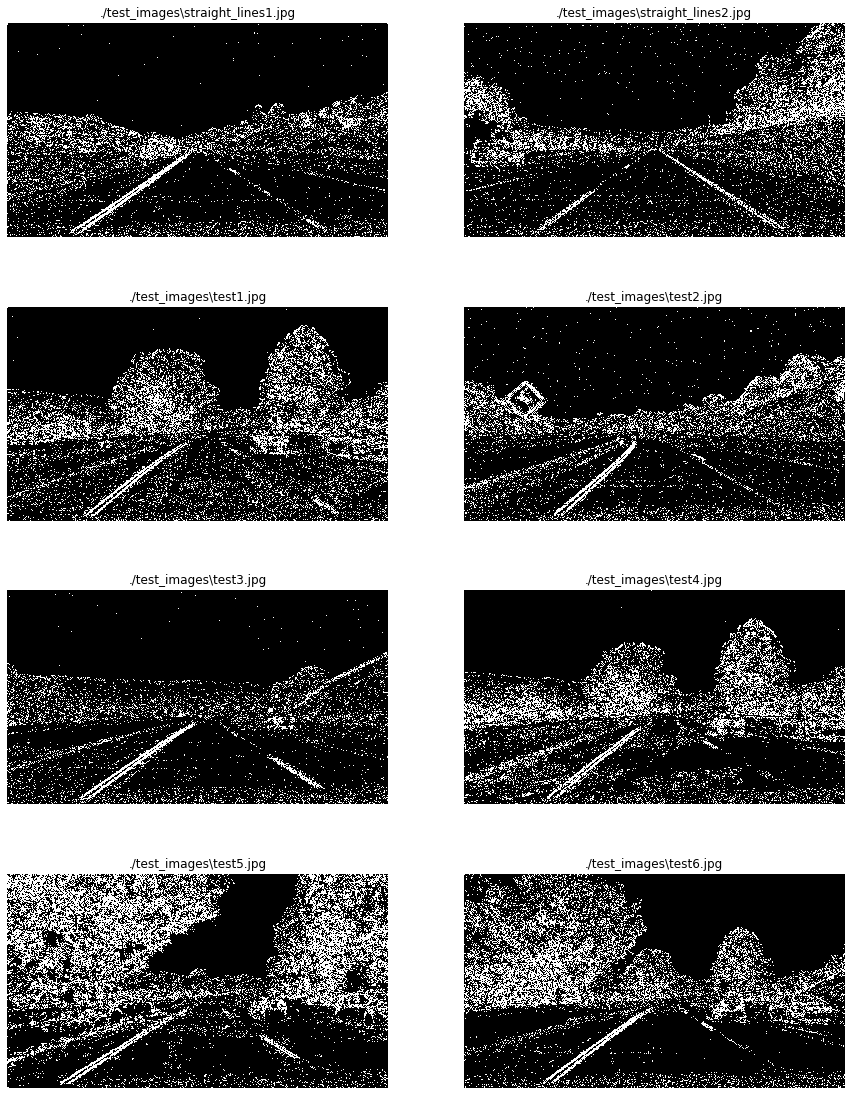

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 20))
combineds = []
for ax, fileName, gradX, gradY, magBin, dirBin in zip(axes.flat, fileNames, gradsX, gradsY, magBinary, dirBinary):
    combined = np.zeros_like(dirBin)
    combined[((gradX == 1) & (gradY == 1)) | ((magBin == 1) & (dirBin == 1))] = 1
    combineds.append(combined)
    ax.imshow(combined, cmap='gray')
    ax.set_title(fileName)
    ax.axis('off')

## Comparison

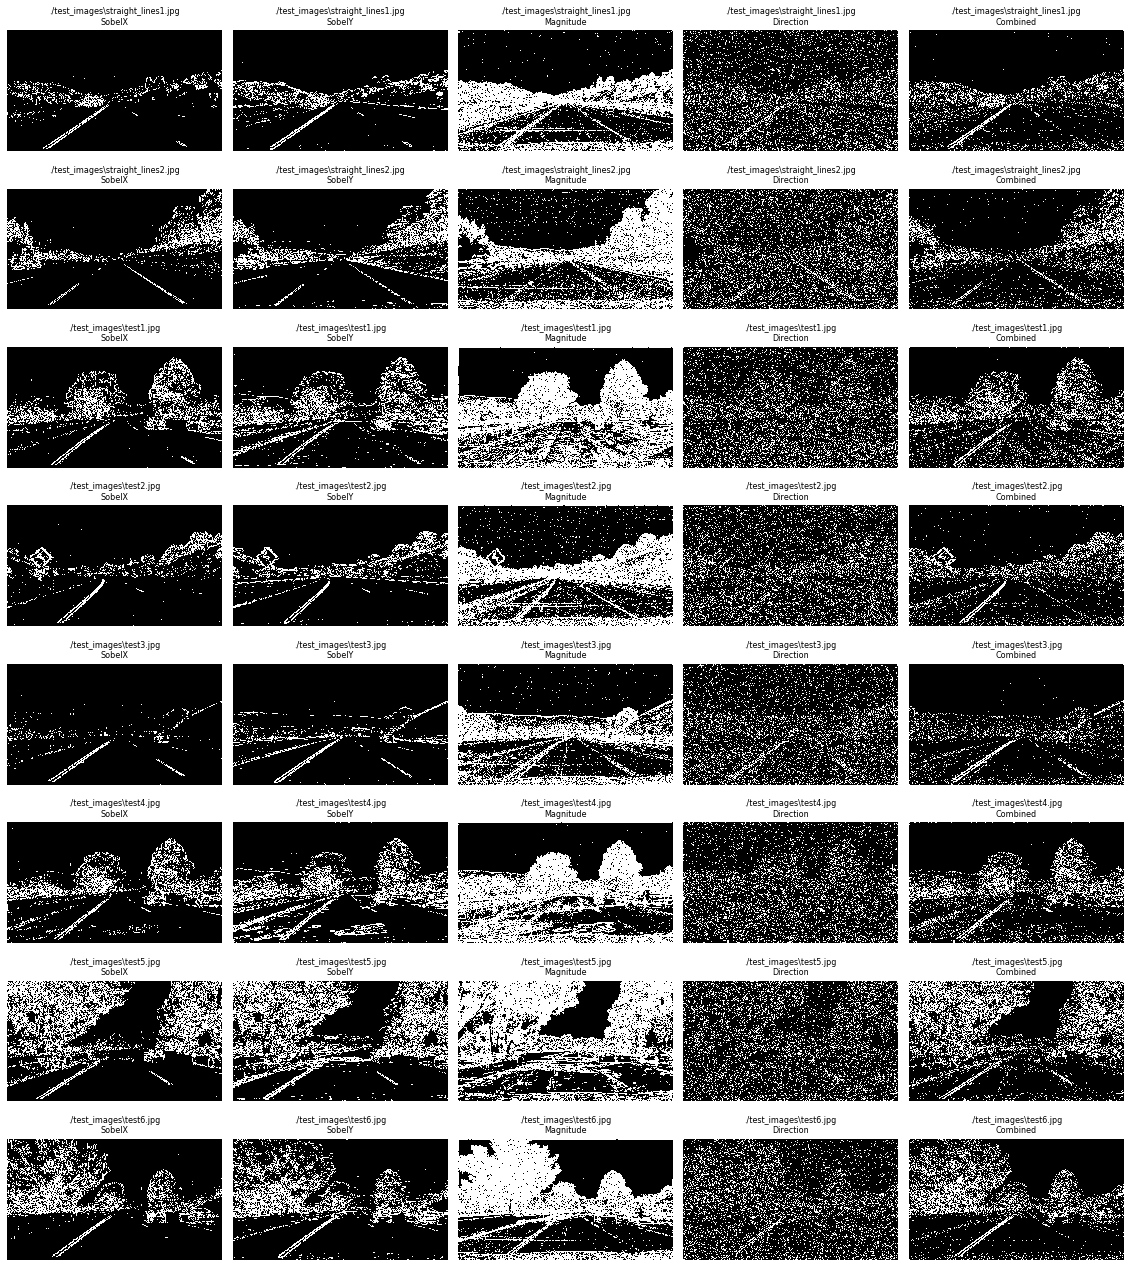

In [12]:
titles = ['SobelX', 'SobelY', 'Magnitude', 'Direction', 'Combined']
results = list(zip( gradsX, gradsY, magBinary, dirBinary, combineds ))
flattenResults = [item for sublist in results for item in sublist]
imagePaths = sorted(fileNames*5)

fig, axes = plt.subplots(ncols=5, nrows=len(fileNames), figsize=(20,20))
for ax, title, flattenResult, imagePath in zip(axes.flat, titles*8, flattenResults, imagePaths):
    ax.imshow(flattenResult, cmap='gray')
    ax.set_title(imagePath + '\n' + title, fontsize=8)
    ax.axis('off')
fig.subplots_adjust(hspace=0, wspace=0.05, bottom=0)